<a id = "cell_Summary"></a>
## 1. Executive Summary

Business problem:
For a gold trading company, predicting gold prices is at heart of the business. While there are many factors that contribute to gold prices at certain period of time, past prices have been mutually agreed as one of the most effective indicators.

Data set:
A data set containing daily gold prices in various currencies (i.e., SD, EUR, GBP, INR, AED, CN) during time period from 1985 to 2023 was given.

Method:
To adequately take into account all data of long periods of time, we will use Recurrent Neural Network (RNN) technique. While the data from 1985 to 2022 will be used to train a time series model, the data from 2022 to 2023 will be used as test data. The gap beween the predicted price and the actual gold price from 2022 to 2023 should tell us how well our predictions are.

Experiments:
Experiments were done on 4 different models. The first three models are univariate and uses the same technique (Recurrent Neural Network). These models differ in values of some parameters. These tweaks were partly random, partly purposeful. The last model is an attempt at multivariate modelling, using the same technique of AI.

Obtained results:
The multivariate model performed the worst out of all 4 models, returning large margin of error even when predicting within short timeframe. The best model is a univariate model, having mean absolute error ranging from 13.36 USD to 47.12 USD depending on length of timeframe.

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(2024)
np.random.seed(2024)

In [ ]:
#Mounting data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/GoldPrice.csv').drop(["EUR", "GBP","INR","AED","CNY"], axis=1)
dataset.head(10)

,Date,USD
0,7/01/1985,298.25
1,8/01/1985,302.00
2,9/01/1985,300.50
3,10/01/1985,303.80
4,11/01/1985,304.25
5,14/01/1985,299.00
6,15/01/1985,301.80
7,16/01/1985,302.70
8,17/01/1985,305.50
9,18/01/1985,308.00


We dropped columns other than 'USD' since we will be making a univariate model. Multi-variate model has been tried but produced worse result. Detail will be discussed further in 'Experiment report'.

In [ ]:
# Convert the date column to DatetimeIndex, specifying dayfirst=True
dataset['Date'] = pd.to_datetime(dataset['Date'], dayfirst=True)

# Set the 'Date' column as the index
dataset.set_index('Date', inplace=True)

# Check data
dataset.head(10)

,USD
Date,
1985-01-07,298.25
1985-01-08,302.00
1985-01-09,300.50
1985-01-10,303.80
1985-01-11,304.25
1985-01-14,299.00
1985-01-15,301.80
1985-01-16,302.70
1985-01-17,305.50


In [ ]:
dataset.isna().sum()

,0
USD,0


No empty cells were detected. The dataset is clean from incomplete data error.

In [ ]:
# Find duplicate index values
duplicate_indices = dataset.index[dataset.index.duplicated()].unique()
print("Duplicate indices:", duplicate_indices)

Duplicate indices: DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


No duplicate were detected. The dataset is clean.

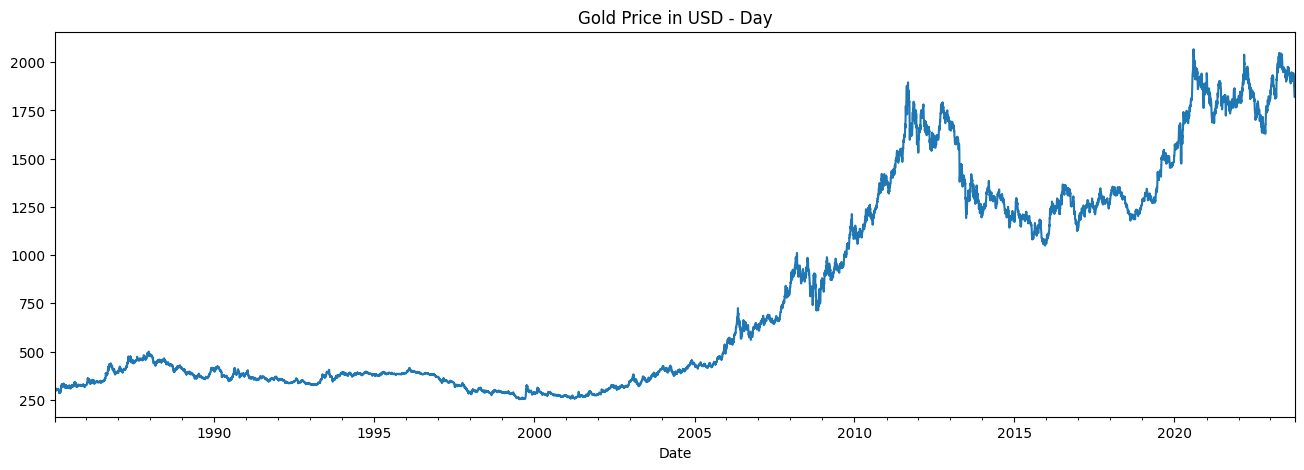

In [ ]:
dataset['USD'].plot(figsize=(16, 5))
plt.title("Gold Price in USD - Day")
plt.show()

From the visualization, it can be seen that there is massive change over time. To adjust for this, we will only use data from 2010 onwards as it is more on par with data after that year (2011-2023).

In [ ]:
#Splitting dataset into train and test set
tstart = 2010
tend = 2021

def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}"]
    test = dataset.loc[f"{tend + 1}":]
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

Dataset is split into training and testing set. The function also determined the time period of training data and testing data as discussed above.

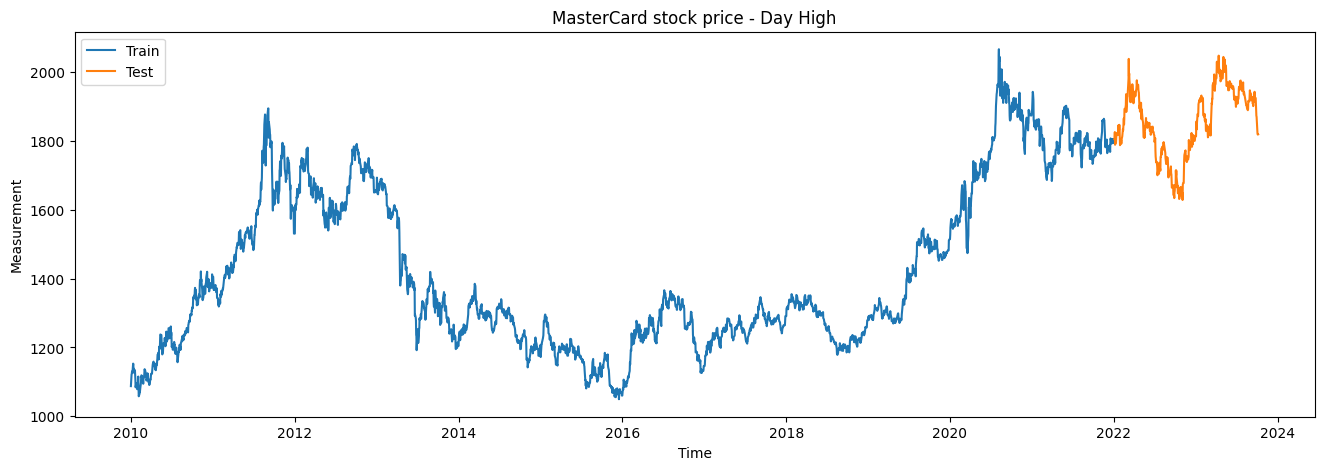

In [ ]:
#Plotting train and testset
plt.figure(figsize=(16, 5))
plt.plot(training_set)
plt.plot(test_set)
plt.title('MasterCard stock price - Day High')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['Train', 'Test'], loc='upper left')

The visualization shows a clear distinction between train and test set. The aim now is to develop a model that make prediction on the yellow side, then compare the gap between them.

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

To be robust against outliers, we scaled the data to a range from 0 to 1. The `MinMaxScaler` feature is used. This will not only scale the data but also help us to rescale the data later.

In [ ]:
def split_sequence(sequence, n_steps,forecasting_horizon):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - forecasting_horizon:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 50
forecasting_horizon = 14
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps,forecasting_horizon)

We defined a function to split the training data into sequences or chunks. Each sequence or chunk is data of 50 days and will be used to predict the data of 14 days after that. These are also possible points to tweak to better the models and their predictions.

In [ ]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

Since the model LSTM only takes 2-D array, we reshaped training data to fit the model.

In [ ]:
#Checking on the shape to ensure correct fitting
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (3068, 50, 1)
y_train shape: (3068, 14, 1)


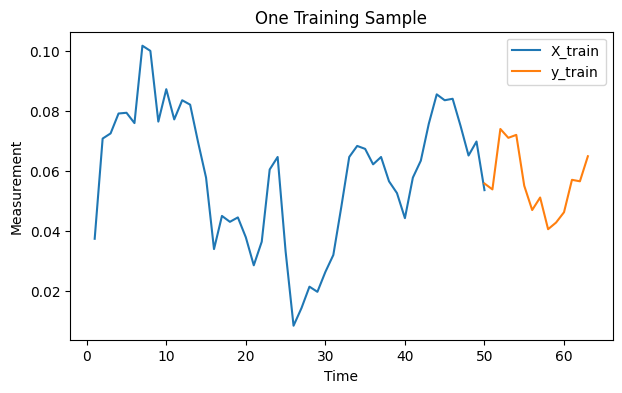

In [ ]:
#Visualize a random sample of training data to check validity
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_train[0])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_train[0])
plt.title('One Training Sample')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_train', 'y_train'], loc='upper right')

<a id = "cell_model"></a>
## 3. Predictive Modeling

In [ ]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=forecasting_horizon))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │         1,414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,214 (164.90 KB)

 Trainable params: 42,214 (164.90 KB)

 Non-trainable params: 0 (0.00 B)

A LSTM model was created. The mode is stacked sequentially with the codes:
- The model has 100 neurons in the first layer and uses `tanh` activation function; the model also takes the parameters of chunks of data that we determined earlier (uses 50 days of data to predict the next 14 days).
- The next layer is an output layer that has an equal number of neurons to the number of days in the future to predict (= 14 days or 2 weeks).

The model is then compiled using `RMSprop` optimizer and use Mean Squared Error as the loss function (which is its metric of success).

In [ ]:
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0325
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0043
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0034
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0026
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0024
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0022
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0021
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0020
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0019
Epoch 10/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0019
Epoch 11/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0018
Epoch 12/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0018
Epoch 13/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0018
Epoch 14/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0018
Epoch 15/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - lo

In [ ]:
#scaling
inputs = test_set.values.reshape(-1, 1)
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps,forecasting_horizon)

# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (397, 50, 1)
y_test shape: (397, 14, 1)


After having a model, we prepared a test set with the same scaling to match the train set preprocessing.

In [ ]:
#Make prediction on gold price
predicted_gold_price = model_lstm.predict(X_test)

#inverse transform the values
predicted_gold_price = sc.inverse_transform(predicted_gold_price)
print('predicted_gold_price shape: ', predicted_gold_price.shape)

#inverse transform the test labels.
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_test = sc.inverse_transform(y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicted_gold_price shape:  (397, 14)


The model is used on the test set. However, after that, we had to inverse the transformation (rescale) the data to make the results immediately interpretable to analysts.

In [ ]:
def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error {:.2f}.".format(mae))

for i in range(forecasting_horizon):
  print("Forecasting Horizon: {} ".format(i))
  return_mae(y_test[:,i],predicted_gold_price[:,i])
  print("")

Forecasting Horizon: 0 
Mean Absolute Error 13.43.

Forecasting Horizon: 1 
Mean Absolute Error 17.92.

Forecasting Horizon: 2 
Mean Absolute Error 19.63.

Forecasting Horizon: 3 
Mean Absolute Error 23.49.

Forecasting Horizon: 4 
Mean Absolute Error 26.75.

Forecasting Horizon: 5 
Mean Absolute Error 30.61.

Forecasting Horizon: 6 
Mean Absolute Error 33.70.

Forecasting Horizon: 7 
Mean Absolute Error 34.82.

Forecasting Horizon: 8 
Mean Absolute Error 38.25.

Forecasting Horizon: 9 
Mean Absolute Error 39.57.

Forecasting Horizon: 10 
Mean Absolute Error 42.32.

Forecasting Horizon: 11 
Mean Absolute Error 43.54.

Forecasting Horizon: 12 
Mean Absolute Error 44.81.

Forecasting Horizon: 13 
Mean Absolute Error 47.51.



For this model, the margin of error in prediction of gold price 1 day ahead it just around 13.36 USD dollar. This number increases steadily as the model is asked to predict for a longer timeframe, reaching 47.12 USD dollar at 2 week timeframe.



It should be noted that although the model was developed using loss function 'Mean Squared Error', it does not make a difference if we use 'Mean Absolute Error' here. These metrics are interexchangeable in most cases (since one is just the square root of another), and we use 'Mean Absolute Error' here just to match unit with original data and make understanding easier.

In [ ]:
#Inverse transform the test data to orignal unit for visualization
X_test = X_test.reshape(-1, 50)
X_test = sc.inverse_transform(X_test)

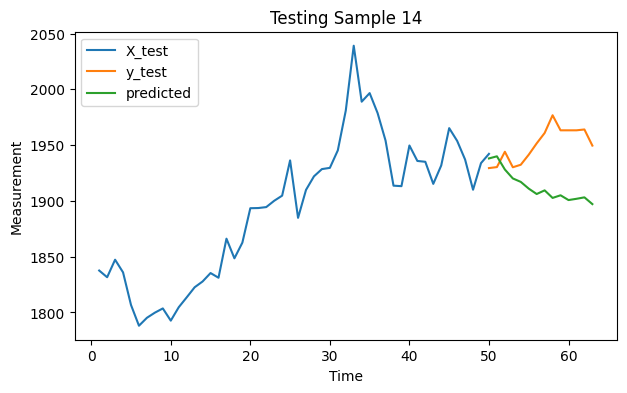

In [ ]:
#Visualize real vs. predicted values of the last testing segment.
sample_index = 14

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),predicted_gold_price[sample_index,:])
plt.title('Testing Sample ' + str(sample_index))
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_test', 'y_test', 'predicted'], loc='upper left')

Plotting the prediction and real data of the last testing segments shows that the model did not predict correctly the overall trend of the data in this timeframe. While actual data showed increase, the model expected it to decrease steadily.

In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Gold Price Prediction")
    plt.xlabel("Days Ahead")
    plt.ylabel("Gold Price")
    plt.legend()
    plt.show()

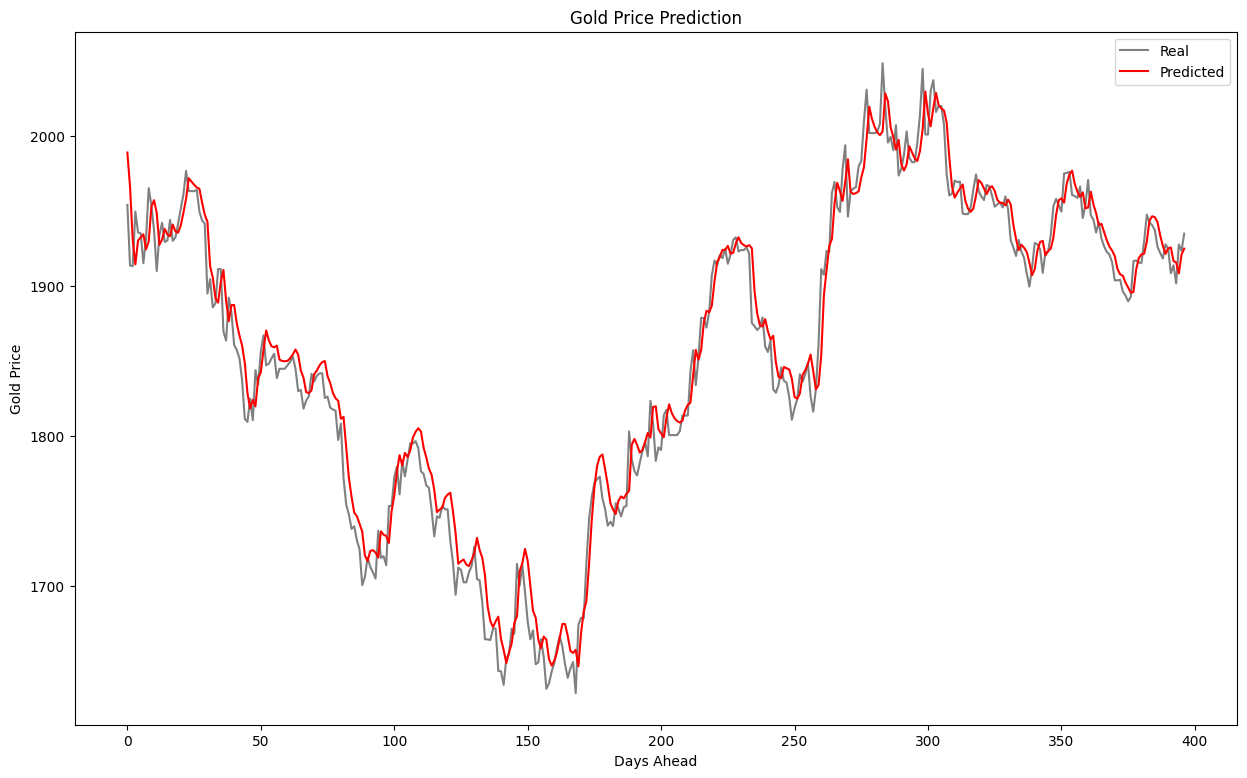

In [ ]:
#Here we visualize the real vs. predicted values for one day forecasting horizon.
plt.figure(figsize=(15, 9))
plot_predictions(y_test[:,0],predicted_gold_price[:,0])

However, when looking at a bigger picture, specifically in all possible timeframe or time horizon, the model followed the pattern of real data well. The major increases and decreases of gold price in USD from 2022 to 2023 were well captured by the predictions.

<a id = "cell_report"></a>
## 4. Experiments Report

### Result discussion

In [ ]:
# Importing relevant libraries for image display
from google.colab import files
from IPython.display import Image

#Import relevant library to read the images
import matplotlib.image as mpimg

In [ ]:
#Choosing images to display

uploaded = files.upload()

In [ ]:
plt.figure(figsize=(5, 10))
img = mpimg.imread('/content/model 1 - MAE per horizon.png')
plt.title('Model 1 - univariate, 50 epochs, RMS optimizer, nstep=50')
plt.imshow(img)

The first model being developed was a  univariate RNN which takes only data on gold price in USD, similar to the model described in previous section. The difference between them lie in the parameters they took. The key different parameters are included in the model title.

As it can be seen, MAE of this model is worse than that of the other model in very forecasting horizon but just slightly so. The slight increases in the other model was achieved by increasing the number of epochs training (50->100).

The simple change also meant that other facets of the model performance stayed the same. This model also failed to recognize short term trend in testing sample but maintain the long term trend in longer time frames. For concise-ness, visualizations of such data will not be shown but are available upon request.

In [ ]:
plt.figure(figsize=(5, 10))
img = mpimg.imread('/content/model 3 - MAE per horizon.png')
plt.title('Model 3 - univariate, 100 epochs, RMS optimizer, nstep=35, time_horizon = 14')
plt.imshow(img)

After achieving higher result with the second model (which is also the model with best performance and is described in detail in previous section), further tweaking was tried to further improve it. Specifically, for this model, nsteps were changed from 50 to 35 to try to capture 'weekly trend' in data if existed. What this effectively did is to shift from using 50 days of data to make prediction for next 2 weeks to using just 35 days or 5 weeks.

However, this did not increase performance and the second model maintained to be the best performing one.

In [ ]:
plt.figure(figsize=(5, 10))
img = mpimg.imread('/content/model 4 - MAE per horizon.png')
plt.title('Model 4 - multivariate, 100 epochs, RMS optimizer, nstep=50, time_horizon = 14')
plt.imshow(img)

An attempt to use multi-variate model was also carried out. This model takes data of gold price in all available currencies, and inherits the parameter values of the second model.

However, MAE levels show that this approach make far worse predictions as MAE in 2 weeks forecasting horizon ranges from 62.06 to 75.83 USD dollar.

In [ ]:
plt.figure(figsize=(10, 5))
img = mpimg.imread('/content/model 4 - real vs predicted.png')
plt.imshow(img)

A quick inpsection into a testing sample showed that this model also could not adequately capture trend in short term. In the tesing sample, while real data seems to fluctate significantly, the model predict much weaker changes.

In [ ]:
plt.figure(figsize=(15, 8))
img = mpimg.imread('/content/model 4- real vs predicted for one day horizons.png')
plt.imshow(img)

Unlike the univariate model, this multi-variate model does not perform better when looking into the entire range of possible horizons. While general trend is somewhat maintained, the model's MAE is likely to be extremely high as the gap between real and predicted data on the graph is big for most sections of the vertical axis.

One possible explanation for this is the relative value of currencies. While USD as currency can get weaker, leading to increase in gold price in USD, other currencies can get stronger,leading to decrease in gold price in those currencies. Such effects would weaken one another and result in less sensitivity in predictions like in the graph above.  Therefore, the best model for predict gold price in USD, given this particular dataset, is the univariate RNN model in previous section.

### Model application to solve business problem

**Application:**

As gold trading company, it can be of strategic value to be able to predict prices at great precision.  A potential way to utilize the model's result is to utilize the credit system, comparing loan rate with maximum loss on trades and ensuring loans (to trade gold) yield positive and significant return on investment.

It should be noted that slight differences in performance is to be expected when trying to reproduce the model or apply in real life. Despite setting consistent randomness in data splitting, there are a lot of other uncontrollable processes underlying the model (e.g., random intialization, libraries' underlying processes, optimizers' behaviour). While the difference should not be significantly large, it might be meaningful in some cases.


**How to improve the model:**

Since the model uses RNN technique, there are a lot of parameters to tweak to attempt at improvement. The model could use more training epochs, use different optimizer (e.g., `Adam`), different number of nsteps, and so on. These possible tweaks could be done using minimal changes to the above codes, but will likely take a lot of time and processing power.

If the technique is not wished to be maintained, other techniques could also be utilized to process the data and make gold price prediction (e.g.,AutoRegressive Integrated Moving Average, Exponential Smooththing, Support Vector Machines).